In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import timm
import torch
import os

device = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
basepath = os.path.abspath('../figures/key-value-and-class-value-agreement')
os.makedirs(basepath, exist_ok=True)

model_names = ['vit_base_patch16_224', 
               'vit_base_patch16_224_miil', 
               'vit_base_patch32_224', 
               'vit_large_patch16_224']
pretty_model_names = {
    'vit_base_patch16_224': 'ViT-B/16', 
    'vit_base_patch16_224_miil': 'ViT-B/16-MIIL', 
    'vit_base_patch32_224': 'ViT-B/32', 
    'vit_large_patch16_224': 'ViT-L/16',
    'imagenet_val': 'ImageNet1k-Val'
}
models = {
    model_name: timm.create_model(model_name, pretrained=True).eval().to(device)
    for model_name in model_names
}


In [2]:
from src.utils.extraction import extract_mhsa_proj_vectors, extract_value_vectors
from src.utils.model import embedding_projection
import src.analyzers.vector_analyzer as an
import torch.nn.functional as F
import db_utils as dbu

classes = 1000
blocks = 12
imgnet_val_db = 'imgnet_val_prelim.db'

projected_values_mlp = {
    model_name: embedding_projection(
        models[model_name], extract_value_vectors(models[model_name], device)) # blocks x 3072 x 1000
    for model_name in model_names
}
projected_values_attn = {
    model_name: embedding_projection(
        models[model_name], extract_mhsa_proj_vectors(models[model_name], device)) # blocks x 768 x 1000
    for model_name in model_names
}

top_per_block_mlp = {
    model_name: an.most_predictive_ind_for_classes_by_block(projected_values_mlp[model_name], device) # blocks x 1000
    for model_name in model_names
}
top_per_block_attn = {
    model_name: an.most_predictive_ind_for_classes_by_block(projected_values_attn[model_name], device) # blocks x 1000
    for model_name in model_names
}

cls_activations = dbu.select(imgnet_val_db, 'select pred_model, num_idx, avg(top_0_score) '
                             'from predictions where num_idx = top_0_ind group by pred_model, num_idx '
                             'order by pred_model, num_idx')
cls_activations = dbu.group_by_tensor(cls_activations, 0, 2, True)

# normalize projected values
for model_name, values in projected_values_mlp.items():
    projected_values_mlp[model_name] /= cls_activations[model_name][None, None, ...]

for model_name, values in projected_values_attn.items():
    projected_values_attn[model_name] /= cls_activations[model_name][None, None, ...]

datapoints_mlp = {
    model_name: torch.empty(blocks, classes)
    for model_name in model_names
}
datapoints_attn = {
    model_name: torch.empty(blocks, classes)
    for model_name in model_names
}

In [3]:
for model_name, indices_mlp in top_per_block_mlp.items():
    scores_of_top = torch.gather(projected_values_mlp[model_name], 1, indices_mlp.unsqueeze(-1).expand(-1, -1, classes))
    scores = scores_of_top[:,torch.arange(classes),torch.arange(classes)]
    if scores.shape[0] > blocks:
        scores = scores.reshape(blocks, 2, classes).mean(dim=1)
    datapoints_mlp[model_name] = scores # scores.sum(dim=-1).cpu() / classes
for model_name, indices_mlp in top_per_block_attn.items():
    scores_of_top = torch.gather(projected_values_attn[model_name], 1, indices_mlp.unsqueeze(-1).expand(-1, -1, classes))
    scores = scores_of_top[:,torch.arange(classes),torch.arange(classes)]
    if scores.shape[0] > blocks:
        scores = scores.reshape(blocks, 2, classes).mean(dim=1)
    datapoints_attn[model_name] = scores # scores.sum(dim=-1).cpu() / classes

datapoints_mlp['imagenet_val'] = torch.ones(blocks, classes)
datapoints_attn['imagenet_val'] = torch.ones(blocks, classes)

e:\Annaconda\envs\vit-interpretability-thesis\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


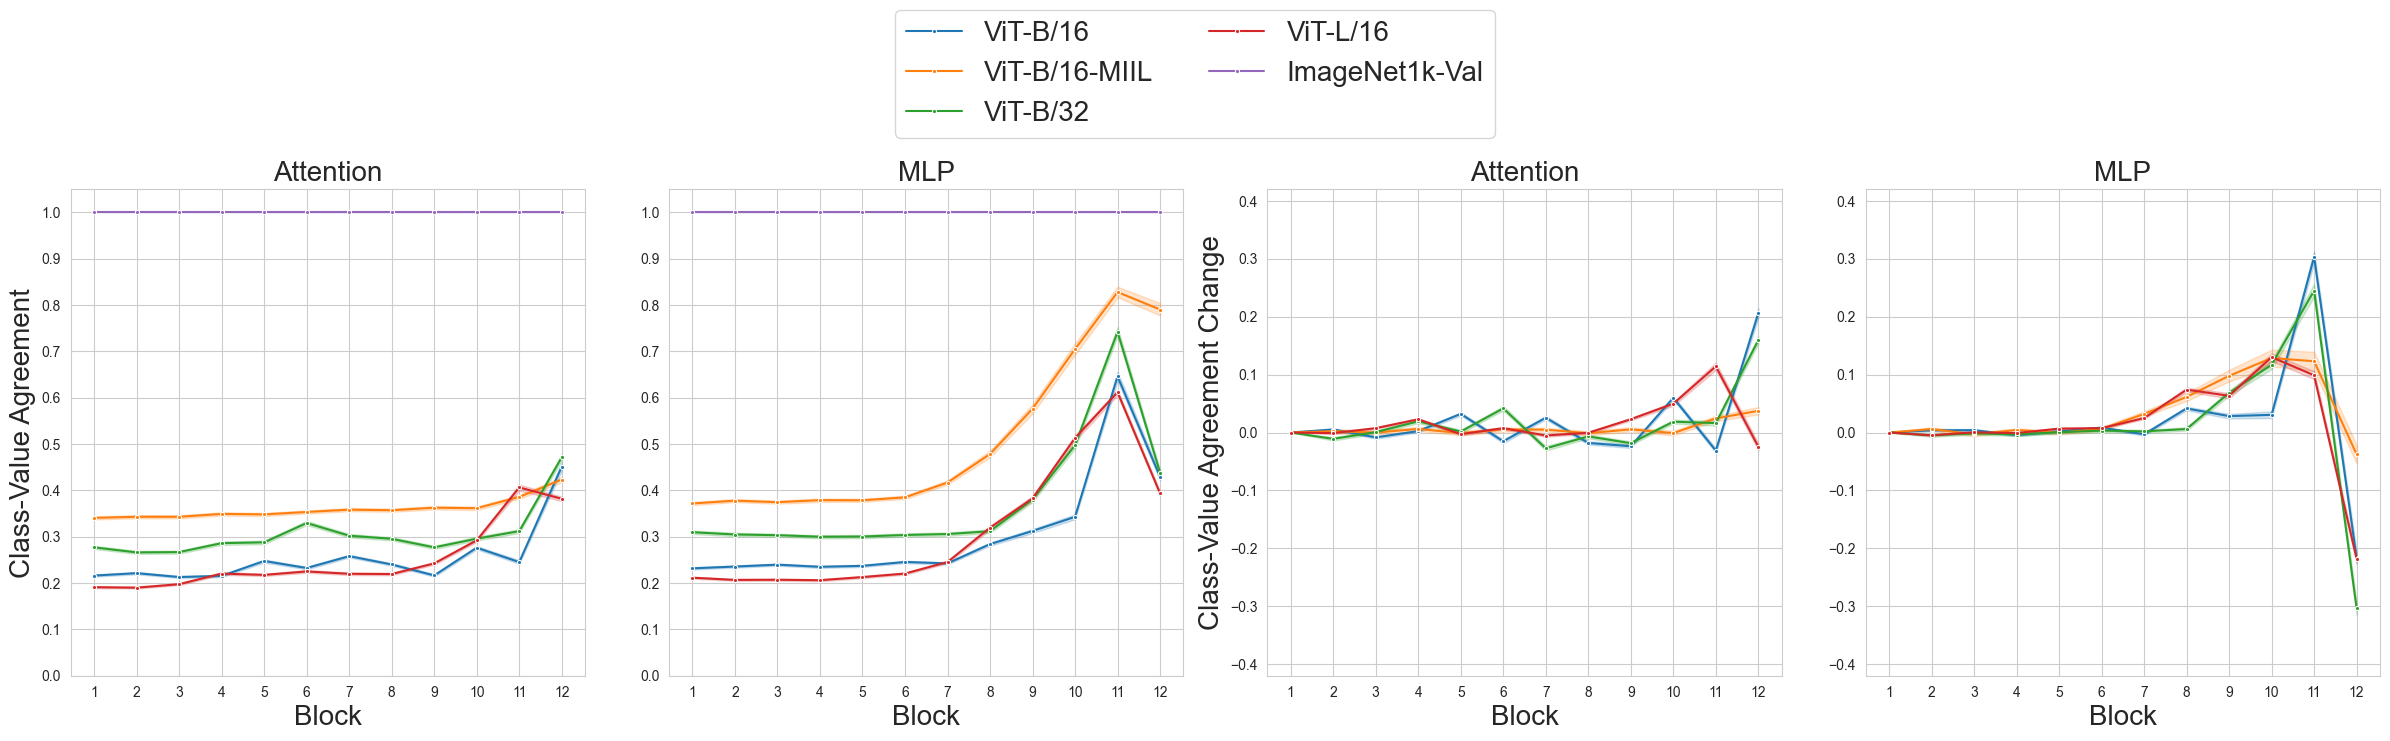

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, (name, data) in enumerate([('Attention', datapoints_attn), ('MLP', datapoints_mlp)]):

    acc_df = pd.DataFrame({'block': [], 'class': [], 'act': [], 'model': []})

    for model_name, datapoints in data.items():
        df = dbu.collect_into_df(datapoints, 'block', 'class', 'act')
        df['block'] = df['block'] + 1
        df['model'] = pretty_model_names[model_name]
        acc_df = pd.concat([acc_df, df])

    sns.lineplot(data=acc_df, x='block', y='act', ax=axes[i], hue='model', markers=True, marker='.')
    axes[i].set_xlabel("Block", fontsize=20)
    axes[i].set_ylabel("Class-Value Agreement", fontsize=20)
    axes[i].set_title(name, fontsize=20)
    axes[i].set_ylim((0, 1.05))
    axes[i].set_xlim()
    axes[i].set_xticks(torch.arange(1, 12+1).numpy())
    axes[i].set_yticks(torch.arange(0, 1+0.1, 0.1).numpy())

for i, (name, data) in enumerate([('Attention', datapoints_attn), ('MLP', datapoints_mlp)]):

    acc_df = pd.DataFrame({'block': [], 'class': [], 'act': [], 'model': []})

    for model_name, datapoints in data.items():
        if model_name != 'imagenet_val':
            datapoints = torch.concat([
                torch.zeros(classes)[None, ...], datapoints[1:] - datapoints[:-1]], dim=0)
            df = dbu.collect_into_df(datapoints, 'block', 'class', 'act')
            df['block'] = df['block'] + 1
            df['model'] = pretty_model_names[model_name]
            acc_df = pd.concat([acc_df, df])

    sns.lineplot(data=acc_df, x='block', y='act', ax=axes[i+2], hue='model', markers=True, marker='.')
    axes[i+2].set_xlabel("Block", fontsize=20)
    axes[i+2].set_ylabel("Class-Value Agreement Change", fontsize=20)
    axes[i+2].set_title(name, fontsize=20)
    axes[i+2].set_ylim((-0.42, 0.42))
    axes[i+2].set_xlim()
    axes[i+2].set_xticks(torch.arange(1, 12+1).numpy())
    axes[i+2].set_yticks(torch.arange(-0.4, 0.4+0.1, 0.1).numpy())

lines, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(
    lines, labels, loc='upper center', ncol=2,
    bbox_to_anchor=(0.5, 1.25), fontsize=20
)
[ax.get_legend().remove() for ax in axes]
[axes[i].set_ylabel('') for i in range(1, len(axes), 2)]
fig.tight_layout()

plt.savefig(os.path.join(basepath, 'class-value-agreement.pdf'), bbox_inches='tight')

plt.show()

In [5]:
k = 7

topk_per_block_mlp = {}
topk_per_block_attn = {}

for model_name in model_names:
    k_most_pred_mlp = an.k_most_predictive_ind_for_classes_by_block(
        projected_values_mlp[model_name], k, device)
    k_most_pred_attn = an.k_most_predictive_ind_for_classes_by_block(
        projected_values_attn[model_name], k, device)
    topk_per_block_mlp[model_name] = [k_most_pred_mlp[:,i] for i in range(k)]
    topk_per_block_attn[model_name] = [k_most_pred_attn[:,i] for i in range(k)]

datapoints_topk_mlp = {
    model_name: [torch.empty(blocks, classes) for _ in range(k)]
    for model_name in model_names
}
datapoints_topk_attn = {
    model_name: [torch.empty(blocks, classes) for _ in range(k)]
    for model_name in model_names
}

for model_name, indices_list in topk_per_block_mlp.items():
    for i, indices_mlp in enumerate(indices_list):
        scores_of_top = torch.gather(projected_values_mlp[model_name], 1, indices_mlp.unsqueeze(-1).expand(-1, -1, classes))
        scores = scores_of_top[:,torch.arange(classes),torch.arange(classes)]
        if scores.shape[0] > blocks:
            scores = scores.reshape(blocks, 2, classes).mean(dim=1)
        datapoints_topk_mlp[model_name][i] = scores

for model_name, indices_list in topk_per_block_attn.items():
    for i, indices_mlp in enumerate(indices_list):
        scores_of_top = torch.gather(projected_values_attn[model_name], 1, indices_mlp.unsqueeze(-1).expand(-1, -1, classes))
        scores = scores_of_top[:,torch.arange(classes),torch.arange(classes)]
        if scores.shape[0] > blocks:
            scores = scores.reshape(blocks, 2, classes).mean(dim=1)
        datapoints_topk_attn[model_name][i] = scores

datapoints_topk_mlp['imagenet_val'] = [torch.ones(blocks, classes) for _ in range(k)]
datapoints_topk_attn['imagenet_val'] = [torch.ones(blocks, classes) for _ in range(k)]

Bbox(x0=0.38624999999999965, y0=24.075, x1=23.85, y1=50.26111111111111)
Bbox(x0=0.1499999999999996, y0=0.1499999999999944, x1=23.85, y1=23.92499999999999)


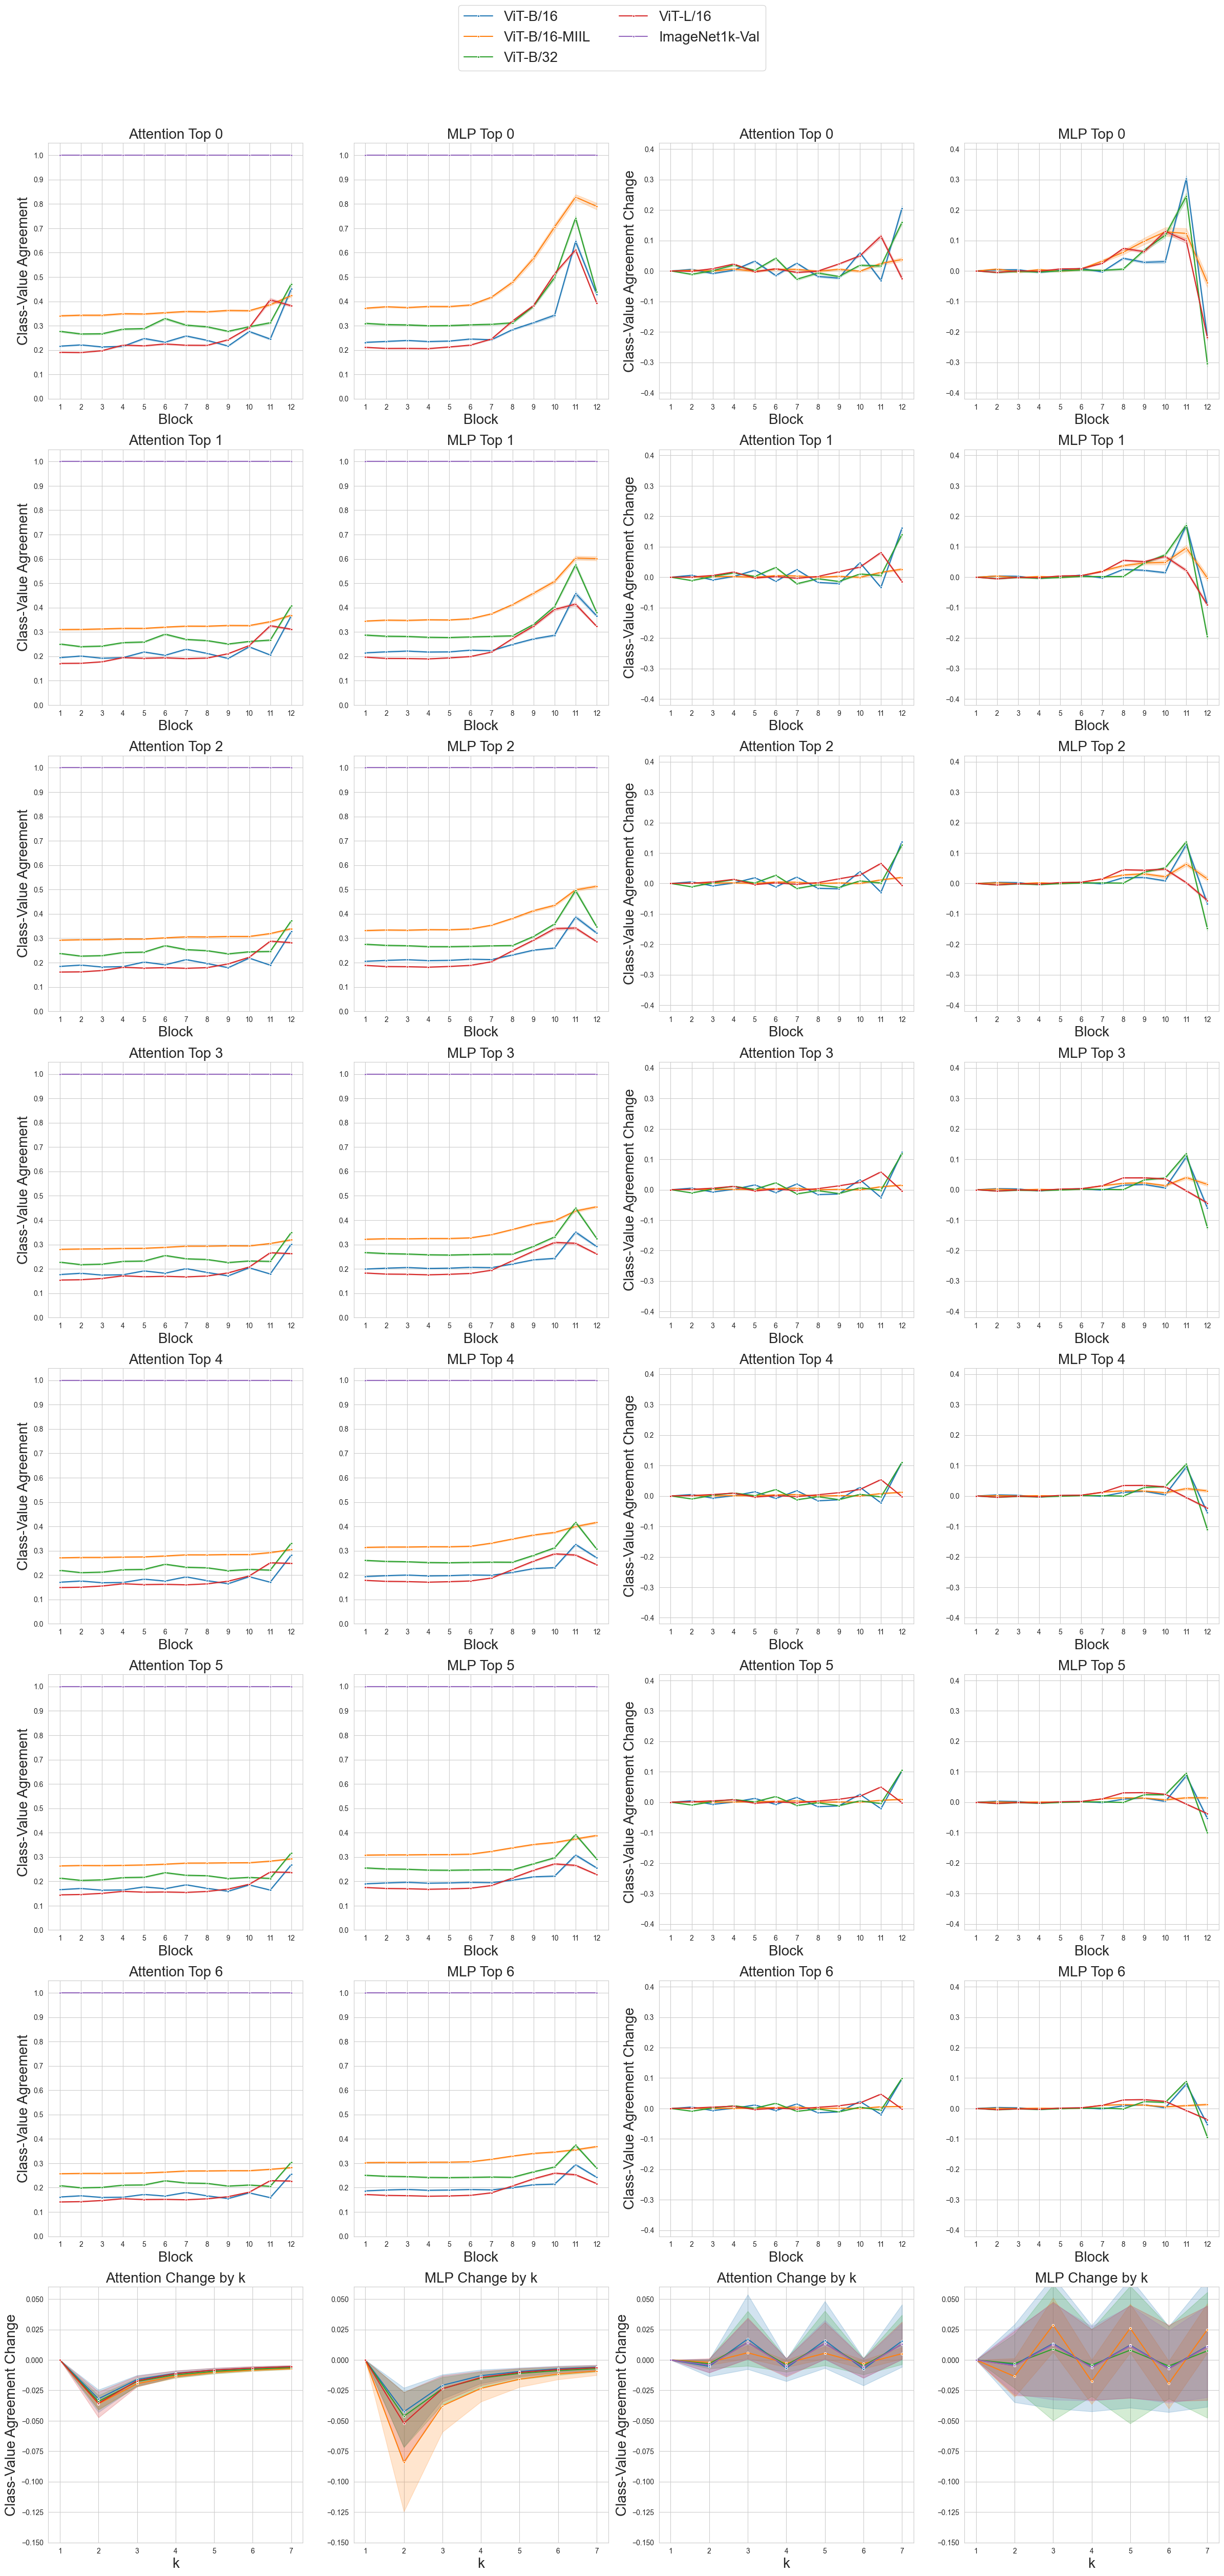

In [6]:
from matplotlib.transforms import Bbox


fig, axes = plt.subplots(k+1, 4, figsize=(24, 6*(k+1)))

for row in range(k):

    for i, (name, data) in enumerate([('Attention', datapoints_topk_attn), ('MLP', datapoints_topk_mlp)]):

        acc_df = pd.DataFrame({'block': [], 'class': [], 'act': [], 'model': []})

        for model_name, datapoints in data.items():
            df = dbu.collect_into_df(datapoints[row], 'block', 'class', 'act')
            df['block'] = df['block'] + 1
            df['model'] = pretty_model_names[model_name]
            acc_df = pd.concat([acc_df, df])

        sns.lineplot(data=acc_df, x='block', y='act', ax=axes[row, i], hue='model', markers=True, marker='.')
        axes[row, i].set_xlabel("Block", fontsize=20)
        axes[row, i].set_ylabel("Class-Value Agreement", fontsize=20)
        axes[row, i].set_title(f'{name} Top {row}', fontsize=20)
        axes[row, i].set_ylim((0, 1.05))
        axes[row, i].set_xlim()
        axes[row, i].set_xticks(torch.arange(1, 12+1).numpy())
        axes[row, i].set_yticks(torch.arange(0, 1+0.1, 0.1).numpy())

    for i, (name, data) in enumerate([('Attention', datapoints_topk_attn), ('MLP', datapoints_topk_mlp)]):

        acc_df = pd.DataFrame({'block': [], 'class': [], 'act': [], 'model': []})

        for model_name, datapoints in data.items():
            datapoints = datapoints[row]
            if model_name != 'imagenet_val':
                datapoints = torch.concat([
                    torch.zeros(classes)[None, ...], datapoints[1:] - datapoints[:-1]], dim=0)
                df = dbu.collect_into_df(datapoints, 'block', 'class', 'act')
                df['block'] = df['block'] + 1
                df['model'] = pretty_model_names[model_name]
                acc_df = pd.concat([acc_df, df])

        sns.lineplot(data=acc_df, x='block', y='act', ax=axes[row, i+2], hue='model', markers=True, marker='.')
        axes[row, i+2].set_xlabel("Block", fontsize=20)
        axes[row, i+2].set_ylabel("Class-Value Agreement Change", fontsize=20)
        axes[row, i+2].set_title(f'{name} Top {row}', fontsize=20)
        axes[row, i+2].set_ylim((-0.42, 0.42))
        axes[row, i+2].set_xlim()
        axes[row, i+2].set_xticks(torch.arange(1, 12+1).numpy())
        axes[row, i+2].set_yticks(torch.arange(-0.4, 0.4+0.1, 0.1).numpy())

for i, (name, data) in enumerate([('Attention', datapoints_topk_attn), ('MLP', datapoints_topk_mlp)]):

    acc_df = pd.DataFrame({'k': [], 'block': [], 'act_change': [], 'model': []})

    for model_name, datapoints in data.items():
        if model_name != 'imagenet_val':
            by_k = torch.empty(k-1, 12)
            for ii in range(1,k):
                by_k[ii-1] = (datapoints[ii] - datapoints[ii-1]).mean(dim=-1)
            by_k = torch.concat([torch.zeros(blocks)[None, ...], by_k])
            df = dbu.collect_into_df(by_k, 'k', 'block', 'act_change')
            df['k'] = df['k'] + 1
            df['model'] = pretty_model_names[model_name]
            acc_df = pd.concat([acc_df, df])

    sns.lineplot(data=acc_df, x='k', y='act_change', ax=axes[k, i], hue='model', markers=True, 
                 marker='.')
    axes[k, i].set_xlabel("k", fontsize=20)
    axes[k, i].set_ylabel("Class-Value Agreement Change", fontsize=20)
    axes[k, i].set_title(f'{name} Change by k', fontsize=20)
    axes[k, i].set_ylim((-0.15, 0.06))
    axes[k, i].set_xlim()
    axes[k, i].set_xticks(torch.arange(1, k+1).numpy())
    axes[k, i].set_yticks(torch.arange(-0.15, 0.06, 0.025).numpy())

for i, (name, data) in enumerate([('Attention', datapoints_topk_attn), ('MLP', datapoints_topk_mlp)]):

    acc_df = pd.DataFrame({'k': [], 'block': [], 'act_change': [], 'model': []})

    for model_name, datapoints in data.items():
        by_k = torch.empty(k, blocks, classes)
        by_k[0] = torch.zeros(blocks, classes)
        row_0 = None
        for row in range(k):
            datapoints_row = datapoints[row]
            if model_name != 'imagenet_val':
                datapoints_row = torch.concat([
                    torch.zeros(classes)[None, ...], datapoints_row[1:] - datapoints_row[:-1]], dim=0)
                if row == 0:
                    row_0 = datapoints_row
                else:
                    by_k[row] = datapoints_row - (by_k[row-1] if row > 1 else row_0)
        by_k = by_k.mean(dim=-1)
        df = dbu.collect_into_df(by_k, 'k', 'block', 'act_change')
        df['k'] = df['k'] + 1
        df['model'] = pretty_model_names[model_name]
        acc_df = pd.concat([acc_df, df])

    sns.lineplot(data=acc_df, x='k', y='act_change', ax=axes[k, i+2], hue='model', markers=True, 
                 marker='.')
    axes[k, i+2].set_xlabel("k", fontsize=20)
    axes[k, i+2].set_ylabel("Class-Value Agreement Change", fontsize=20)
    axes[k, i+2].set_title(f'{name} Change by k', fontsize=20)
    axes[k, i+2].set_ylim((-0.15, 0.06))
    axes[k, i+2].set_xlim()
    axes[k, i+2].set_xticks(torch.arange(1, k+1).numpy())
    axes[k, i+2].set_yticks(torch.arange(-0.15, 0.06, 0.025).numpy())


lines, labels = axes[0, 0].get_legend_handles_labels()
lgd = fig.legend(
    lines, labels, loc='upper center', ncol=2,
    bbox_to_anchor=(0.5, 1.05), fontsize=20
)
[axes[row,col].get_legend().remove() for row in range(k+1) for col in range(4)]
[axes[row, i].set_ylabel('') for i in range(1, len(axes[0]), 2) for row in range(k+1)]
fig.tight_layout()
plt.savefig(os.path.join(basepath, 'class-value-agreement-topk.pdf'), bbox_inches='tight')

for i in range(0, (k+1)//4):
    extent = axes[i*4, 0].get_tightbbox().transformed(fig.dpi_scale_trans.inverted())
    if i == 0:
        extent = Bbox.union([extent,
            lgd.get_window_extent(renderer=fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())])
    for row in range(4):
        for col in range(4):
            if not (row == 0 and col == 0):
                extension = axes[i*4+row, col].get_tightbbox().transformed(
                    fig.dpi_scale_trans.inverted())
                extent = Bbox.union([extent, extension])
    fig.savefig(os.path.join(basepath, f'class-value-agreement-topk-{i}.pdf'), bbox_inches=extent)

plt.show()

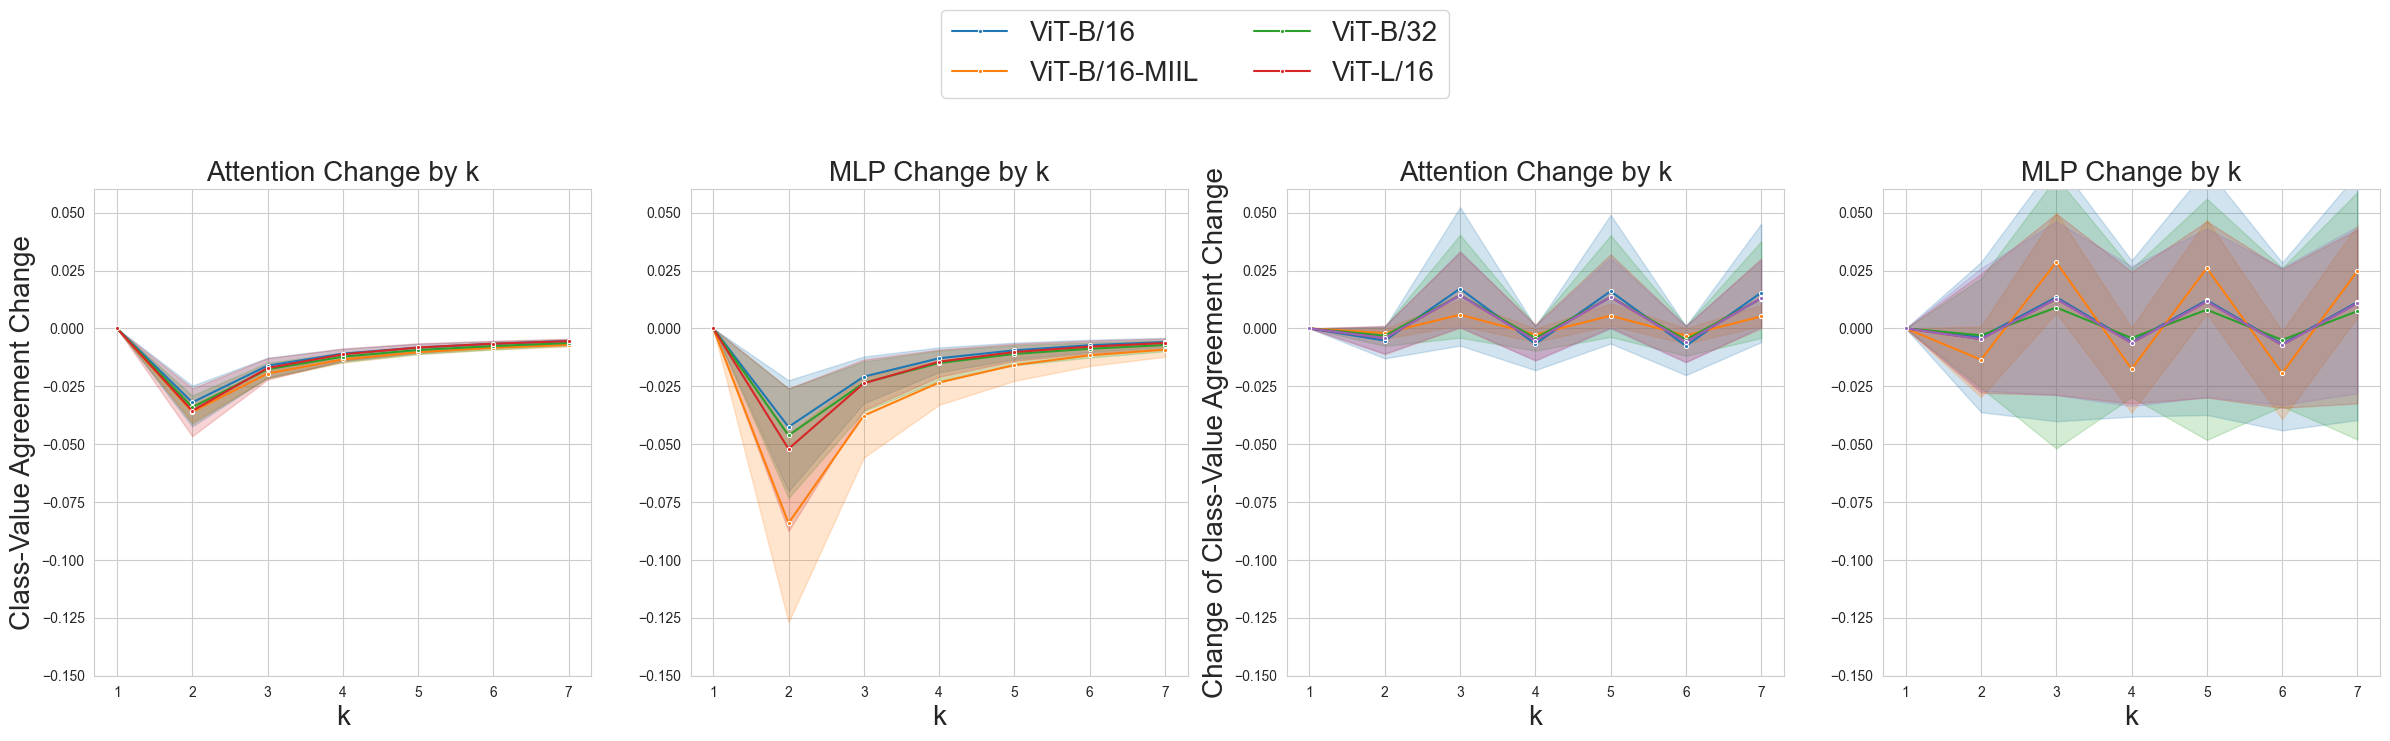

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, (name, data) in enumerate([('Attention', datapoints_topk_attn), ('MLP', datapoints_topk_mlp)]):

    acc_df = pd.DataFrame({'k': [], 'block': [], 'act_change': [], 'model': []})

    for model_name, datapoints in data.items():
        if model_name != 'imagenet_val':
            by_k = torch.empty(k-1, 12)
            for ii in range(1,k):
                by_k[ii-1] = (datapoints[ii] - datapoints[ii-1]).mean(dim=-1)
            by_k = torch.concat([torch.zeros(blocks)[None, ...], by_k])
            df = dbu.collect_into_df(by_k, 'k', 'block', 'act_change')
            df['k'] = df['k'] + 1
            df['model'] = pretty_model_names[model_name]
            acc_df = pd.concat([acc_df, df])

    sns.lineplot(data=acc_df, x='k', y='act_change', ax=axes[i], hue='model', markers=True, 
                 marker='.')
    axes[i].set_xlabel("k", fontsize=20)
    axes[i].set_ylabel("Class-Value Agreement Change", fontsize=20)
    axes[i].set_title(f'{name} Change by k', fontsize=20)
    axes[i].set_ylim((-0.15, 0.06))
    axes[i].set_xlim()
    axes[i].set_xticks(torch.arange(1, k+1).numpy())
    axes[i].set_yticks(torch.arange(-0.15, 0.06, 0.025).numpy())

for i, (name, data) in enumerate([('Attention', datapoints_topk_attn), ('MLP', datapoints_topk_mlp)]):

    acc_df = pd.DataFrame({'k': [], 'block': [], 'act_change': [], 'model': []})

    for model_name, datapoints in data.items():
        by_k = torch.empty(k, blocks, classes)
        by_k[0] = torch.zeros(blocks, classes)
        row_0 = None
        for row in range(k):
            datapoints_row = datapoints[row]
            if model_name != 'imagenet_val':
                datapoints_row = torch.concat([
                    torch.zeros(classes)[None, ...], datapoints_row[1:] - datapoints_row[:-1]], dim=0)
                if row == 0:
                    row_0 = datapoints_row
                else:
                    by_k[row] = datapoints_row - (by_k[row-1] if row > 1 else row_0)
        by_k = by_k.mean(dim=-1)
        df = dbu.collect_into_df(by_k, 'k', 'block', 'act_change')
        df['k'] = df['k'] + 1
        df['model'] = pretty_model_names[model_name]
        acc_df = pd.concat([acc_df, df])

    sns.lineplot(data=acc_df, x='k', y='act_change', ax=axes[i+2], hue='model', markers=True, 
                 marker='.')
    axes[i+2].set_xlabel("k", fontsize=20)
    axes[i+2].set_ylabel("Change of Class-Value Agreement Change", fontsize=20)
    axes[i+2].set_title(f'{name} Change by k', fontsize=20)
    axes[i+2].set_ylim((-0.15, 0.06))
    axes[i+2].set_xlim()
    axes[i+2].set_xticks(torch.arange(1, k+1).numpy())
    axes[i+2].set_yticks(torch.arange(-0.15, 0.06, 0.025).numpy())

lines, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(
    lines, labels, loc='upper center', ncol=2,
    bbox_to_anchor=(0.5, 1.25), fontsize=20
)
[axes[col].get_legend().remove()for col in range(4)]
[axes[i].set_ylabel('') for i in range(1, len(axes), 2)]
fig.tight_layout()
plt.savefig(os.path.join(basepath, 'class-value-agreement-topk-change.pdf'), bbox_inches='tight')
plt.show()

In [31]:
from torchvision.models.feature_extraction import create_feature_extractor
from src.analyzers.vector_analyzer import k_most_predictive_ind_for_classes_by_block
import numpy as np
from tqdm.auto import tqdm
from src.datasets.ImageNet import ImageNetValDataset
from src.utils.transformation import get_transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for model_name, model in models.items():
    models[model_name] = model.eval().to(device)

k = 5
batch_size = 3

imgs_per_cat = 5
random_categories = 150

imagenet = ImageNetValDataset('A:\\CVData\\ImageNet', 
                              {
                                  'miil': get_transforms(models['vit_base_patch16_224_miil']),
                                  'common': get_transforms(models['vit_base_patch16_224'])
                              })

indices_mlp = {
    model_name: k_most_predictive_ind_for_classes_by_block( # 12 x k x 1000
    embedding_projection(models[model_name], 
                         extract_value_vectors(models[model_name], device), device), k, device)
    for model_name in model_names
}
indices_attn = {
    model_name: k_most_predictive_ind_for_classes_by_block( # 12 x k x 1000
    embedding_projection(models[model_name], 
                         extract_mhsa_proj_vectors(models[model_name], device), device), k, device)
    for model_name in model_names
}

imagenet_classes = imagenet.get_imagenet_classes()

sums_by_block_mlp = {
    model_name: {
        i: [0 for _ in range(len(models[model_name].blocks))]
        for i in range(k) 
    }
    for model_name in model_names
}
sums_by_block_attn = {
    model_name: {
        i: [0 for _ in range(len(models[model_name].blocks))]
        for i in range(k) 
    }
    for model_name in model_names
}
extract_layers = {
    model_name: [f'blocks.{i}.mlp.fc1' for i in range(len(models[model_name].blocks))]
    for model_name in model_names
}
extractors = {
    model_name: create_feature_extractor(models[model_name], extract_layers[model_name])
    for model_name in model_names
}

extracted_mhsa_proj_key = {
    model_name: [i for i in range(len(models[model_name].blocks))]
    for model_name in model_names
}
def attach_mhsa_key_retriever(extractor, model_name: str, block_ind: int):
    global extracted_mhsa_proj_key

    def hook(module, input, output):
        extracted_mhsa_proj_key[model_name][block_ind] = input[0].detach()

    handle = (
        extractor.blocks.get_submodule(str(block_ind)).attn.proj.register_forward_hook(hook))

    return handle

removable_handles = [
    attach_mhsa_key_retriever(extractors[model_name], model_name, i)
    for model_name in model_names for i in range(len(models[model_name].blocks))]

for cls_ind in tqdm(range(len(imagenet_classes))):
    imagenet.lock_category(imagenet_classes[cls_ind])
    ds_indices = np.random.default_rng().choice(len(imagenet), size=imgs_per_cat, replace=False)

    for i in range(0, len(ds_indices), batch_size):

        length = min(len(ds_indices)-i, batch_size)
        items = [imagenet[ds_indices[i+ii]] for ii in range(length)]

        tensor_images_common = torch.stack([items[ii]['img_common'] 
                                            for ii in range(length)], dim=0).to(device)
        tensor_images_miil = torch.stack([items[ii]['img_miil'] 
                                          for ii in range(length)], dim=0).to(device)

        for model_name in model_names:

            out = extractors[model_name](tensor_images_miil 
                                         if model_name.endswith('miil') else tensor_images_common)
            for i, layer in enumerate(extract_layers[model_name]):
                top_k_key_indices_mlp = out[layer].topk(k, dim=-1)[1]
                top_k_key_indices_attn = extracted_mhsa_proj_key[model_name][i].topk(
                    k, dim=-1)[1]
                for ii in range(k):
                    sums_by_block_mlp[model_name][ii][i] += torch.sum(
                        torch.any(torch.isin(top_k_key_indices_mlp, 
                                            indices_mlp[model_name][i,:ii+1,cls_ind]), dim=-1)
                    ).item()
                    sums_by_block_attn[model_name][ii][i] += torch.sum(
                        torch.any(torch.isin(top_k_key_indices_attn, 
                                            indices_attn[model_name][i,:ii+1,cls_ind]), dim=-1)
                    ).item()
    
        for item in items:
            del item['img_common']
            del item['img_miil']
        del tensor_images_common
        del tensor_images_miil
        del top_k_key_indices_mlp
        del out
        torch.cuda.empty_cache()


[handle.remove() for handle in removable_handles]

for model_name in model_names:
    for i in range(k):
        sums_by_block_mlp[model_name][i] = [
            sums_by_block_mlp[model_name][i][ii] / (imgs_per_cat * len(imagenet_classes) * 
                                            (models[model_name].patch_embed.num_patches + 1))
            for ii in range(len(sums_by_block_mlp[model_name][i]))]
        sums_by_block_attn[model_name][i] = [
            sums_by_block_attn[model_name][i][ii] / (imgs_per_cat * len(imagenet_classes) * 
                                            (models[model_name].patch_embed.num_patches + 1))
            for ii in range(len(sums_by_block_attn[model_name][i]))]
        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
sums_by_block_mlp

{'vit_base_patch16_224': {0: [0.0025228426395939086,
   0.0018101522842639594,
   0.0016649746192893401,
   0.001247715736040609,
   0.0028091370558375635],
  1: [0.004636548223350254,
   0.003651776649746193,
   0.003246700507614213,
   0.002551269035532995,
   0.0044913705583756345],
  2: [0.006815228426395939,
   0.005284263959390863,
   0.004815228426395939,
   0.003753299492385787,
   0.00627005076142132],
  3: [0.009221319796954315,
   0.007044670050761421,
   0.006355329949238579,
   0.005060913705583757,
   0.008359390862944162],
  4: [0.011687309644670052,
   0.0093248730964467,
   0.0077624365482233506,
   0.006534010152284264,
   0.010142131979695431]},
 'vit_base_patch16_224_miil': {0: [0.0016802030456852792,
   0.001419289340101523,
   0.001433502538071066,
   0.0012111675126903554,
   0.001552284263959391],
  1: [0.003138071065989848,
   0.002812182741116751,
   0.00286497461928934,
   0.0029137055837563453,
   0.003181725888324873],
  2: [0.004676142131979696,
   0.00420

In [9]:
models[model_names[0]]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F